In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np 
 
from torchvision import transforms
from norb import smallNORB

# ref https://discuss.pytorch.org/t/difference-between-torch-manual-seed-and-torch-cuda-manual-seed/13848/7
seed_value = 42
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `pytorch` pseudo-random generator at a fixed value
import torch
torch.manual_seed(seed_value)


Load the test loader

In [2]:

def get_test_loader(data_dir,
                    dataset,
                    batch_size, 
                    num_workers=4,
                    pin_memory=False):

    data_dir = data_dir + '/' + dataset

    from torchvision.transforms import InterpolationMode
    if dataset == "smallNorb":
        trans = [
                   #  During test, we crop a 32 Ã— 32 patch from the center of the image. Matrix capsules
            # with em routing
                transforms.Resize(48, interpolation=InterpolationMode.BICUBIC),
                transforms.CenterCrop(32),
                transforms.ToTensor(),
                 ]
        dataset = smallNORB(data_dir, train=False, download=True,
                                transform=transforms.Compose(trans))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    print("type of test_loader", type(data_loader))
    print("Length of test_loader", len(data_loader))
    return data_loader


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': False}
batch_size = 64
test_loader = get_test_loader("./data", "smallNorb", batch_size, **kwargs)
num_test = len(test_loader.dataset)
print("Length of testing dataset", num_test)

type of test_loader <class 'torch.utils.data.dataloader.DataLoader'>
Length of test_loader 760
Length of testing dataset 48600


In [4]:
import torch
import torch.nn as nn
from models import resnet20


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torchvision
from torchvision.models.resnet import Bottleneck, ResNet


class Capsule(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the output after the average pooling layer.
    """

    def __init__(self, encoder, caps_net):
        super(Capsule, self).__init__()
        self.encoder = encoder
        self.caps_net = caps_net

        # Replace the fc layer with an Identity function
        self.encoder.fc = nn.Identity()
        self.encoder.avgpool = nn.Identity()


    def forward(self, x_i):      
        x_i = self.encoder.conv1(x_i) 
        x_i = self.encoder.bn1(x_i) 
        x_i = self.encoder.relu(x_i) 
        x_i = self.encoder.layer1(x_i)  
        x_i = self.encoder.layer2(x_i) 
        x_i = self.encoder.layer3(x_i) 
        h_i = self.encoder.layer4(x_i) 
        z_i = self.caps_net(h_i) 
        return z_i
    
def get_resnet(name, pretrained=False):
    resnets = {
        "resnet18": torchvision.models.resnet18(pretrained=pretrained),
        "resnet50": torchvision.models.resnet50(pretrained=pretrained),
    }
    if name not in resnets.keys():
        raise KeyError(f"{name} is not a valid ResNet version")
    return resnets[name]

def modify_resnet_model(model, *, cifar_stem=True, v1=True):
    """Modifies some layers of a given torchvision resnet model to
    match the one used for the CIFAR-10 experiments in the SimCLR paper.

    Parameters
    ----------
    model : ResNet
        Instance of a torchvision ResNet model.
    cifar_stem : bool
        If True, adapt the network stem to handle the smaller CIFAR images, following
        the SimCLR paper. Specifically, use a smaller 3x3 kernel and 1x1 strides in the
        first convolution and remove the max pooling layer.
    v1 : bool
        If True, modify some convolution layers to follow the resnet specification of the
        original paper (v1). torchvision's resnet is v1.5 so to revert to v1 we switch the
        strides between the first 1x1 and following 3x3 convolution on the first bottleneck
        block of each of the 2nd, 3rd and 4th layers.

    Returns
    -------
    Modified ResNet model.
    """
    assert isinstance(model, ResNet), "model must be a ResNet instance"
    if cifar_stem:
        conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        nn.init.kaiming_normal_(conv1.weight, mode="fan_out", nonlinearity="relu")
        model.conv1 = conv1
        model.maxpool = nn.Identity()
        model.fc = nn.Identity()
    if v1:
        for l in range(2, 5):
            layer = getattr(model, "layer{}".format(l))
            block = list(layer.children())[0]
            if isinstance(block, Bottleneck):
                assert block.conv1.kernel_size == (1, 1) and block.conv1.stride == (
                    1,
                    1,
                )
                assert block.conv2.kernel_size == (3, 3) and block.conv2.stride == (
                    2,
                    2,
                )
                assert block.conv2.dilation == (
                    1,
                    1,
                ), "Currently, only models with dilation=1 are supported"
                block.conv1.stride = (2, 2)
                block.conv2.stride = (1, 1)
    return model

In [5]:
encoder = get_resnet("resnet18", pretrained=False).to(device)
modified_resnet = modify_resnet_model(encoder).to(device)

capsule_network = resnet20(16, {'size': 32, 'channels': 1, 'classes': 5}, 32, 16, 1, mode="EM").to(device)
model = Capsule(modified_resnet,  capsule_network)
           
checkpoint = torch.load("checkpoints/resnet_em_routing_model_best.pth.tar", map_location=device)  
model.load_state_dict(checkpoint['model_state'], strict=True)
model = model.to(device)
model = model.eval()


c:\Users\athac\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\athac\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
import torch
import json
# all of our models had 32 capsules
num_capsules = 32
# initialise them as 0
accumulated_activations = torch.zeros(num_capsules, device=device)

# Counter for the number of validation samples
num_samples = 0

for i, (x, y) in enumerate(test_loader):
    x = x.to(device) 
    with torch.no_grad(): 
        out = model(x)
    # Sum activations across the spatial dimensions for each capsule
    # and accumulate these sums across all validation samples
    accumulated_activations += torch.sum(out, dim=[0, 2, 3])
    # count the batches that have been processed
    num_samples += x.size(0)

# our activations are 4x4 (check the resnet file for more)
# so we divide by 16 to get the average activation per capsule element
average_activations = accumulated_activations / (num_samples * 16)  

average_activations_list = average_activations.cpu().tolist()

# Sanity checks
print("num_samples", num_samples)
print("accumulated_activations", accumulated_activations)
print("Average activations per capsule element:", average_activations_list)

# Save them to a JSON file for proof
data_to_save = {
    "capsule_averages": average_activations_list
}
file_path = 'capsules_averages/EM_supervised_capsule_averages_all.json'
with open(file_path, 'w') as f:
    json.dump(data_to_save, f, indent=4)

print(f"Saved activations averages to {file_path}")

num_samples 48600
accumulated_activations tensor([366951.6250, 371612.0938, 367964.3750, 364221.0000, 372290.1875,
        371186.8438, 369420.0625, 375232.7812, 368002.0000, 368144.5938,
        365214.2500, 370116.7812, 370166.4062, 368633.6250, 371791.1875,
        366823.8125, 368854.2500, 365514.7500, 371437.6562, 366885.7500,
        363302.6250, 373460.3125, 370378.0938, 371361.1875, 367888.5312,
        374730.9062, 370158.6875, 366348.8438, 365595.1875, 365761.3125,
        367789.4375, 370652.0000], device='cuda:0')
Average activations per capsule element: [0.4719028174877167, 0.47789621353149414, 0.47320520877838135, 0.46839120984077454, 0.4787682294845581, 0.47734934091567993, 0.47507724165916443, 0.4825524389743805, 0.47325360774993896, 0.47343698143959045, 0.46966853737831116, 0.4759732186794281, 0.47603705525398254, 0.4740658700466156, 0.47812652587890625, 0.47173842787742615, 0.47434958815574646, 0.4700549840927124, 0.47767189145088196, 0.47181808948516846, 0.4672101736

Convert to a List for easier process

In [7]:
values_list = []
for value in data_to_save.values():
    values_list.extend(value)  
print("Flattened list of values:", values_list)

Flattened list of values: [0.4719028174877167, 0.47789621353149414, 0.47320520877838135, 0.46839120984077454, 0.4787682294845581, 0.47734934091567993, 0.47507724165916443, 0.4825524389743805, 0.47325360774993896, 0.47343698143959045, 0.46966853737831116, 0.4759732186794281, 0.47603705525398254, 0.4740658700466156, 0.47812652587890625, 0.47173842787742615, 0.47434958815574646, 0.4700549840927124, 0.47767189145088196, 0.47181808948516846, 0.46721017360687256, 0.48027303814888, 0.47630926966667175, 0.47757354378700256, 0.4731076657772064, 0.48190703988075256, 0.47602713108062744, 0.47112762928009033, 0.4701584279537201, 0.4703720510005951, 0.47298023104667664, 0.4766615331172943]


round to 2 decimals as per the literature
https://arxiv.org/abs/2305.11178

In [8]:
avg = [round(num, 2) for num in values_list]
avg

[0.47,
 0.48,
 0.47,
 0.47,
 0.48,
 0.48,
 0.48,
 0.48,
 0.47,
 0.47,
 0.47,
 0.48,
 0.48,
 0.47,
 0.48,
 0.47,
 0.47,
 0.47,
 0.48,
 0.47,
 0.47,
 0.48,
 0.48,
 0.48,
 0.47,
 0.48,
 0.48,
 0.47,
 0.47,
 0.47,
 0.47,
 0.48]

Visualisation

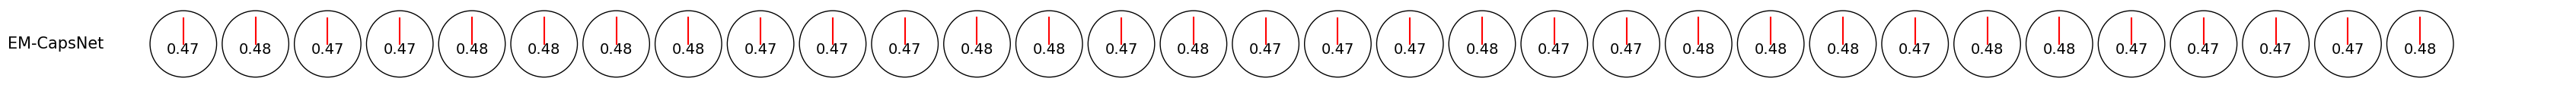

In [9]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

activations = avg 

fig, ax = plt.subplots(figsize=(34, 2.8))

# this is the space between circles
space_between_circles = 0.3 

# I make a circle for each capsule
for i, activation in enumerate(activations):
    circle_center = i * (1 + space_between_circles) + 1  
    circle = plt.Circle((circle_center, 0), 0.6, color='black', fill=False)
    ax.add_patch(circle)
    ax.plot([circle_center, circle_center], [0, activation], color='red')  
    ax.text(circle_center, -0.1, f'{activation:.2f}', ha='center', va='center', fontsize=14)

# add the name before the capsules at left 
ax.text(-1.3, 0, 'EM-CapsNet', ha='center', va='center', fontsize=15)
ax.set_aspect('equal')
ax.axis('off')

# save into pdf for higher quality
plt.tight_layout()
plt.savefig('graphs_for_thesis/supervised_em_smallnorb.pdf', format='pdf')  
plt.show()